In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from IPython.display import Image
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report, ConfusionMatrixDisplay,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

import joblib

In [25]:
# read data and rename column names for better readability and clarity.
new_columns = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness', 'target']

df_train = pd.read_csv('data/pulsar_data_train.csv')
df_test = pd.read_csv('data/pulsar_data_test.csv')

df_train.columns = new_columns
df_test.columns = new_columns
df_train.head()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_SNR_mean,DM_SNR_std,DM_SNR_kurtosis,DM_SNR_skewness,target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [26]:
# perform train-validation-test split
#read in again to remove previous changes
new_columns = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness', 'target']

df = pd.read_csv('data/pulsar_data_train.csv')
df.columns = new_columns

In [27]:
# define features and target
features = df.drop(columns='target')
target = df['target']

# First split: Training data and rest (validation data + test data)
X_train, X_rest, y_train, y_rest = train_test_split(features, target,
                                                    test_size=0.3,
                                                    random_state=42)

# Second split: Test data and validation data
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest,
                                                test_size=0.5,
                                                random_state=42)

In [28]:
# Handle missing values
num_cols = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness']

cat_cols = []

cleaner = ColumnTransformer(transformers=[("knn_imputer", KNNImputer(n_neighbors=5, weights="uniform"), num_cols)],
                            remainder = "passthrough"
                           )

# apply imputing on datasets
X_train = pd.DataFrame(cleaner.fit_transform(X_train), columns=num_cols)
X_val = pd.DataFrame(cleaner.transform(X_val), columns=num_cols)
X_test = pd.DataFrame(cleaner.transform(X_test), columns=num_cols)

#print(X_train.info(), X_test.info(), X_val.info())

In [29]:
# helper function to compare the scores of the different models
model_results = []

def calculate_scores(y_val, y_pred, name):
    """
    Calculates and returns the accuracy, precision, recall, and F1 score for the given validation and predicted labels.

    Args:
        y_val (array-like): The true labels for the validation set.
        y_pred (array-like): The predicted labels for the validation set.
        name (str): The name of the model used to make the predictions.

    Returns:
        dict: A dictionary containing the name of the model and the calculated accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1_scr = f1_score(y_val, y_pred)

    scores = {'name': name,
              'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
              'F1': f1_scr,
              }

    return scores

In [30]:
# define f1 score 
def f1_score_ann(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [31]:
# preprocessing for ANN
scaler = StandardScaler()
# apply preprocessing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
# apply SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)


In [32]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow)
tf.keras.utils.set_random_seed(42)

#dropout rate for dropout layers
dropout_rate = 0.5

# define model
model_ann = Sequential()

# define hidden layers
hidden_1 = Dense(units=8, activation='relu', input_dim=X_train_sampled.shape[1])
hidden_2 = Dense(units=8, activation='relu')

# define the dropout layers
dropout_1 = Dropout(rate=dropout_rate, seed=42)
dropout_2 = Dropout(rate=dropout_rate, seed=42)

# define output layer
output_layer  = Dense(units=1, activation='sigmoid')

# add layers 
model_ann.add(hidden_1)
model_ann.add(dropout_1)
model_ann.add(hidden_2)
model_ann.add(dropout_2)
model_ann.add(output_layer)
print(model_ann.summary())
#-----------------------------------------------------------------------------------------
# Optimizer
adam_custom = Adam(learning_rate=0.0005) #default 0.001

#-----------------------------------------------------------------------------------------
# compile model    
model_ann.compile(optimizer=adam_custom, loss='binary_crossentropy', metrics=[f1_score_ann])

#---------------------------------------------------------------------------------------------
# early stopping for regularization
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10)

# train model 
hist_ann = model_ann.fit(X_train_sampled,
                         y_train_sampled,
                         epochs=100, 
                         batch_size=512,
                         verbose=0,
                         callbacks=[early_stop],
                         validation_data=(X_val_scaled, y_val))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# Predict and print classification report of validation data------------------------------------------------------------
y_pred = (model_ann.predict(X_val_scaled) > 0.5).astype('int8')
y_true = y_val
print(classification_report(y_true, y_pred, digits=4))

59/59 [==============================] - 0s 693us/step
              precision    recall  f1-score   support

         0.0     0.9848    0.9894    0.9871      1698
         1.0     0.8966    0.8571    0.8764       182

    accuracy                         0.9766      1880
   macro avg     0.9407    0.9233    0.9317      1880
weighted avg     0.9762    0.9766    0.9764      1880



59/59 [==============================] - 0s 665us/step
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9889    0.9871    0.9880      1708
         1.0     0.8736    0.8889    0.8812       171

    accuracy                         0.9782      1879
   macro avg     0.9312    0.9380    0.9346      1879
weighted avg     0.9784    0.9782    0.9783      1879

ROC_AUC_Score : 0.9776182258926003
------------------------------------------------------------


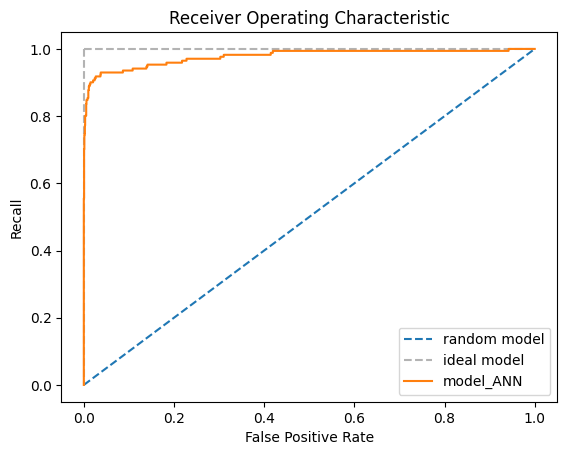

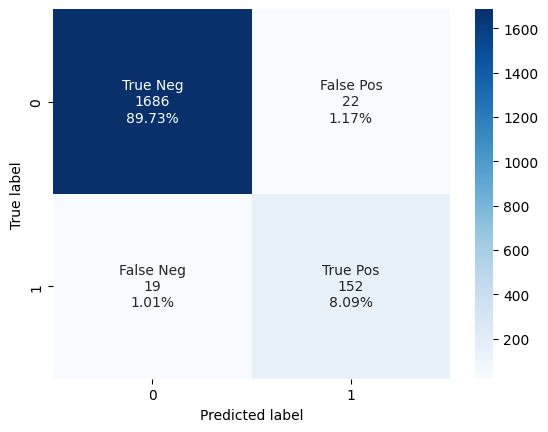

In [34]:
# predict on test data and print results --------------------------------------------------------------
y_pred1 = (model_ann.predict(X_test_scaled) > 0.5).astype('int8')
y_pred_proba1 = model_ann.predict(X_test_scaled)
y_true = y_test

print('---'*20)
print(classification_report(y_true, y_pred1, digits=4))
print('ROC_AUC_Score :', roc_auc_score(y_true, y_pred_proba1))
print('---'*20)

#--------------------------------------------------------------------
# calculate roc curve values for the ROC curve
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_pred_proba1,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title('Receiver Operating Characteristic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.legend()
#--------------------------------------------------------------------
# visualize the confusion matrix

# figure and axes intialisation
fig, ax = plt.subplots()

cm = confusion_matrix(y_true, y_pred1)

# Setting up values to add more information; labels, percentage, counts
cm_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
cm_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# Applying the labels and values
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names,cm_counts,cm_percent)]
labels = np.asarray(labels).reshape(2,2)

# Plotting the confusion matrix
sns.heatmap(cm, annot=labels, cmap="Blues", fmt="")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

In [35]:
# append results to model_results dataframe
model_results.append(calculate_scores(y_true, y_pred1, name='ANN'))
pd.DataFrame(model_results)

,name,accuracy,precision,recall,F1
0,ANN,0.97818,0.873563,0.888889,0.881159


In [36]:
# preprocessing for ANN
from sklearn.preprocessing import MinMaxScaler, RobustScaler
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=24))
])

# apply preprocessing
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)
X_val_scaled = pipeline.transform(X_val)

# apply SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)




In [37]:
tf.keras.utils.set_random_seed(42)

dropout_rate = 0.75

# define model
model_ann = Sequential()

# define hidden layers
hidden_1 = Dense(units=24, activation='relu', input_dim=X_train_sampled.shape[1])
hidden_2 = Dense(units=24, activation='relu')

# define the dropout layers
dropout_1 = Dropout(rate=dropout_rate, seed=42)
dropout_2 = Dropout(rate=dropout_rate, seed=42)

# define output layer
output_layer  = Dense(units=1, activation='sigmoid')

# add layers 
model_ann.add(hidden_1)
model_ann.add(dropout_1)
model_ann.add(hidden_2)
model_ann.add(dropout_2)
model_ann.add(output_layer)
print(model_ann.summary())
#-----------------------------------------------------------------------------------------
from tensorflow.keras.optimizers import Adam
adam_custom = Adam(learning_rate=0.00051) # deafult 0.001

#-----------------------------------------------------------------------------------------
# compile model    

model_ann.compile(optimizer=adam_custom, loss='binary_crossentropy', metrics=[f1_score_ann])

#---------------------------------------------------------------------------------------------

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10)
#early_stop = EarlyStopping(monitor='val_f1_score_ann', min_delta=1e-7, patience=20, mode='max')

# train model 
hist_ann = model_ann.fit(X_train_sampled,
                         y_train_sampled,
                         epochs=100, 
                         batch_size=256,
                         verbose=0,
                         #callbacks=[early_stop],
                         validation_data=(X_val_scaled, y_val))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24)                600       
                                                                 
 dropout_6 (Dropout)         (None, 24)                0         
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dropout_7 (Dropout)         (None, 24)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________
None


59/59 [==============================] - 0s 794us/step
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9872    0.9959    0.9915      1708
         1.0     0.9551    0.8713    0.9113       171

    accuracy                         0.9846      1879
   macro avg     0.9712    0.9336    0.9514      1879
weighted avg     0.9843    0.9846    0.9842      1879

ROC_AUC_Score : 0.9862258104277086
------------------------------------------------------------


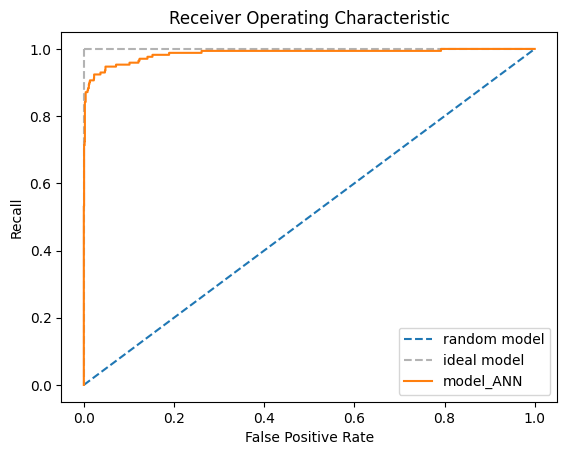

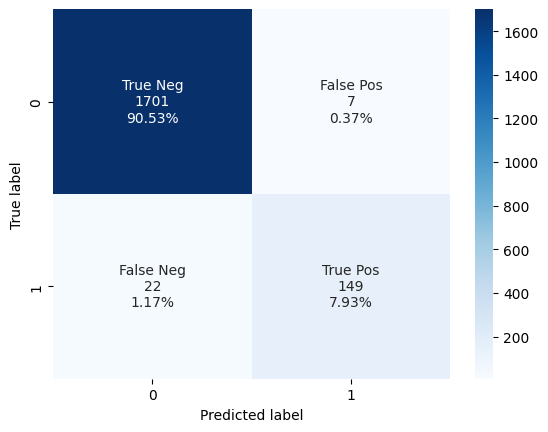

In [38]:
# predict on test data and print results --------------------------------------------------------------
y_pred2 = (model_ann.predict(X_test_scaled) > 0.5).astype('int8')
y_pred_proba2 = model_ann.predict(X_test_scaled)
y_true = y_test

print('---'*20)
print(classification_report(y_true, y_pred2, digits=4))
print('ROC_AUC_Score :', roc_auc_score(y_true, y_pred_proba2))
print('---'*20)

#--------------------------------------------------------------------
# calculate roc curve values for the ROC curve
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_pred_proba2,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title('Receiver Operating Characteristic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.legend()
#--------------------------------------------------------------------
# visualize the confusion matrix

# figure and axes intialisation
fig, ax = plt.subplots()

cm = confusion_matrix(y_true, y_pred2)

# Setting up values to add more information; labels, percentage, counts
cm_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
cm_percent = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

# Applying the labels and values
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names,cm_counts,cm_percent)]
labels = np.asarray(labels).reshape(2,2)

# Plotting the confusion matrix
sns.heatmap(cm, annot=labels, cmap="Blues", fmt="")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

In [39]:
model_results.append(calculate_scores(y_true, y_pred2, name='ANN_Poly_PCA'))

pd.DataFrame(model_results)

,name,accuracy,precision,recall,F1
0,ANN,0.978180,0.873563,0.888889,0.881159
1,ANN_Poly_PCA,0.984566,0.955128,0.871345,0.911315


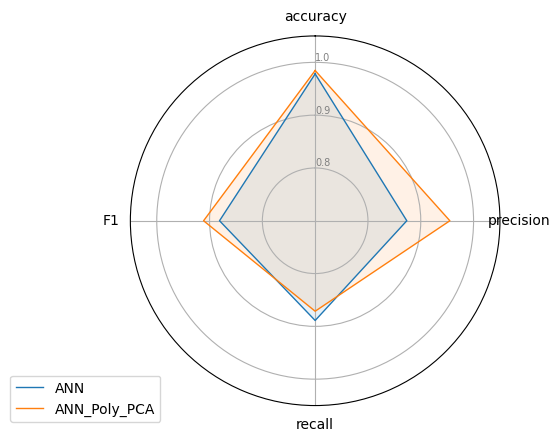

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Create a DataFrame from the data provided
data = {'name': ['ANN', 'ANN_Poly_PCA'],
        'accuracy': [0.978180, 0.984566],
        'precision': [0.873563, 0.955128],
        'recall': [0.888889, 0.871345],
        'F1': [0.881159, 0.911315]}
df = pd.DataFrame(data)

# Set the number of variables and the angle of each axis
categories = list(df)[1:]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialize the radar chart
ax = plt.subplot(111, polar=True)

# Set the first axis on top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories)

# Set the y-axis range
ax.set_rlabel_position(0)
plt.yticks([0.8, 0.9, 1.0], ["0.8", "0.9", "1.0"], color="grey", size=7)
plt.ylim(0.7, 1.05)

# Plot the data for each model
for i, row in df.iterrows():
    values = df.loc[i].drop('name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['name'])
    ax.fill(angles, values, alpha=0.1)

#ax.set_title('ANN comparison')
# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))



save_flag = 0

if save_flag == 1:

    plt.savefig('plots/Radar_ANN_comparison.png')

plt.show()


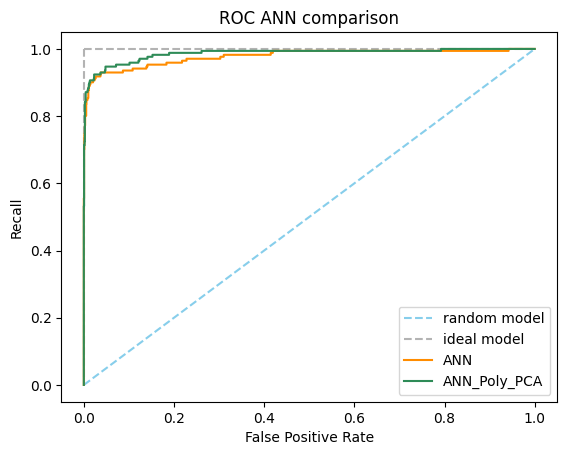

In [63]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# calculate roc curve values for the first ROC curve
false_positive_rate1, recall1, threshold1 = roc_curve(y_test, y_pred_proba1, drop_intermediate=False)

# calculate roc curve values for the second ROC curve
false_positive_rate2, recall2, threshold2 = roc_curve(y_test, y_pred_proba2, drop_intermediate=False)

# figure and axes initialization
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls="--", c='skyblue', alpha=1, label='random model')  # blue diagonal with alpha=0.5
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curves
ax.plot(false_positive_rate1, recall1, label='ANN', c='darkorange')
ax.plot(false_positive_rate2, recall2, label='ANN_Poly_PCA', c='seagreen')

# labels
ax.set_title('ROC ANN comparison')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Recall')
ax.legend();



save_flag = 0

if save_flag == 1:

    plt.savefig('plots/ROC_ANN_comparison.png')

plt.show()


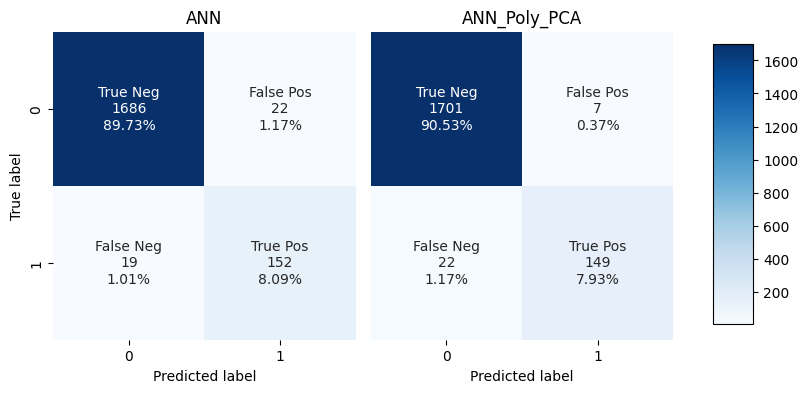

In [64]:
# calculate confusion matrices
cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)

# figure and axes initialization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

# Setting up values to add more information; labels, percentage, counts
cm_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
cm_counts1 = ["{0:.0f}".format(value) for value in cm1.flatten()]
cm_counts2 = ["{0:.0f}".format(value) for value in cm2.flatten()]
cm_percent1 = ["{0:.2%}".format(value) for value in cm1.flatten()/np.sum(cm1)]
cm_percent2 = ["{0:.2%}".format(value) for value in cm2.flatten()/np.sum(cm2)]

# Applying the labels and values
labels1 = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names, cm_counts1, cm_percent1)]
labels1 = np.asarray(labels1).reshape(2, 2)
labels2 = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(cm_names, cm_counts2, cm_percent2)]
labels2 = np.asarray(labels2).reshape(2, 2)

# Plotting the confusion matrices
sns.heatmap(cm1, annot=labels1, cmap="Blues", fmt="", ax=ax1, cbar=False)
sns.heatmap(cm2, annot=labels2, cmap="Blues", fmt="", ax=ax2, cbar=False)

ax1.set_title('ANN')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

ax2.set_title('ANN_Poly_PCA')
ax2.set_xlabel('Predicted label')
ax2.set_yticklabels([])
ax2.set_yticks([])

plt.subplots_adjust(wspace=0.05)

# Add a colorbar to the right figure
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(ax2.collections[0], cax=cbar_ax)




save_flag = 0

if save_flag == 1:

    plt.savefig('plots/Matrix_ANN_comparison.png')

plt.show()

